In [1]:
import scvelo as scv
import numpy as np  
import matplotlib.pyplot as plt

import anndata

import sys
sys.path.append("..")


import cellpath as cp
import cellpath.visual as visual
import cellpath.benchmark as bmk 
import cellpath.de_analy as de


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

## Meta-cell construction

In [2]:
num_trajs = 6
include_all_cells = True
num_metacells = 400

In [3]:
# read in simulated dataset
# adata = anndata.read_h5ad("./sim_data/Dyngen/Trifurcating.h5ad")
adata = anndata.read_h5ad("../sim_data/Dyngen/Trifurcating_clust.h5ad")

In [4]:
cellpath_obj = cp.CellPath(adata = adata)
cellpath_obj.all_in_one(num_metacells = num_metacells, n_neighs = 10, pruning = False, insertion = include_all_cells, num_trajs = num_trajs)

Already conducted clustering
Meta-cell constructed
Meta-cell level neighborhood graph constructed
cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  177_348 , len:  39 newly covered: 39
start_end:  388_281 , len:  37 newly covered: 22
start_end:  250_136 , len:  31 newly covered: 16
start_end:  261_7 , len:  35 newly covered: 12
start_end:  261_79 , len:  37 newly covered: 6
start_end:  177_315 , len:  34 newly covered: 7
start_end:  261_301 , len:  39 newly covered: 2
start_end:  261_158 , len:  39 newly covered: 2
start_end:  261_28 , len:  39 newly covered: 1
start_end:  261_18 , len:  39 newly covered: 1
start_end:  261_154 , len:  39 newly covered: 1
start_end:  261_118 , len:  38 newly covered: 1
start_end:  261_121 , len:  38 newly covered: 1
Finished
Cell-level pseudo-time inferred


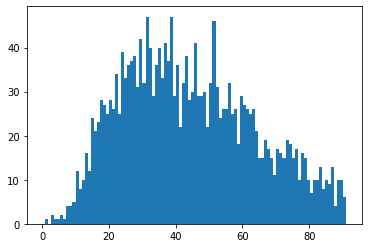

In [5]:
visual.weight_histogram(cellpath_obj, resolution = 100)

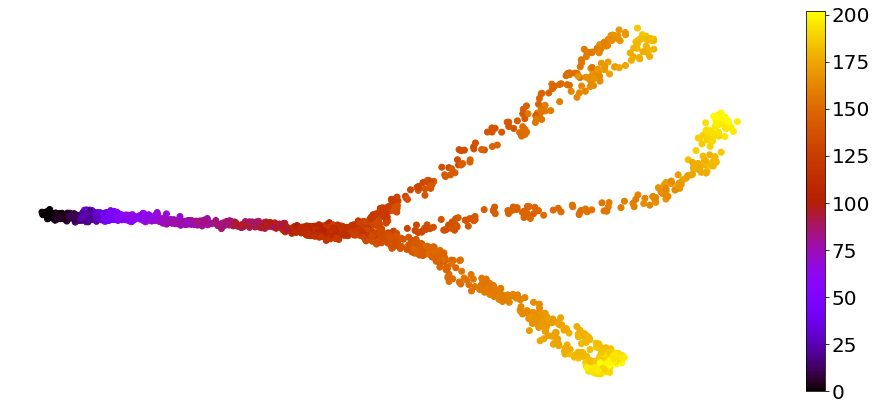

In [6]:
visual.plot_data(cellpath_obj, basis = "pca", figsize = (15,7), save_as = None)

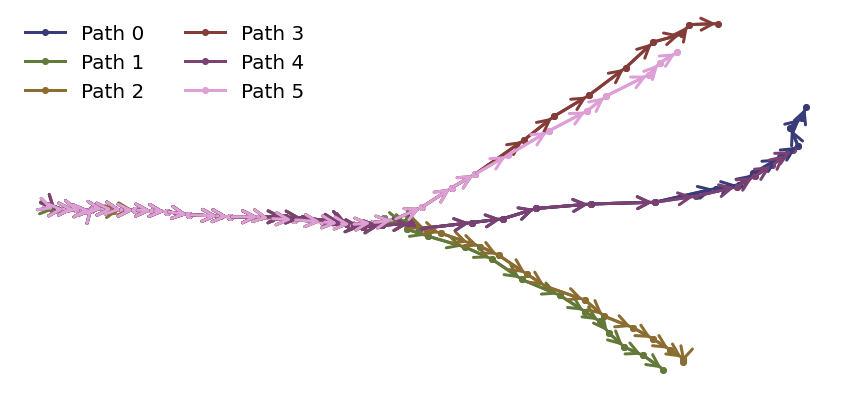

In [8]:
visual.meta_traj_visual(cellpath_obj, basis = "pca", trajs = num_trajs, figsize = (15,7), save_as = None, legend_pos = "upper left", axis = False)

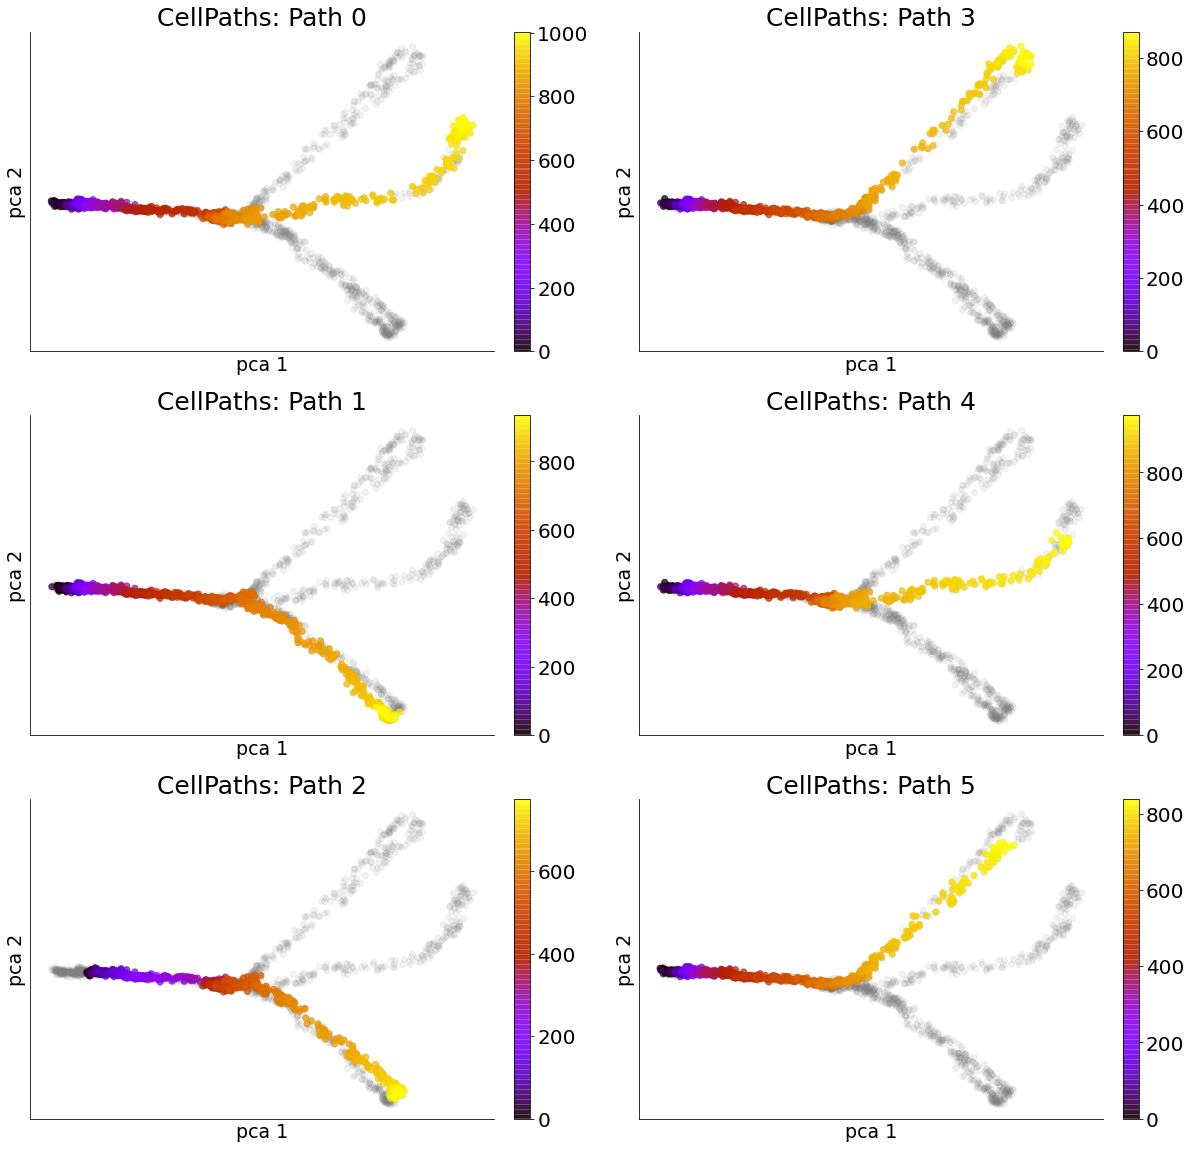

In [9]:
visual.first_order_approx_pt(cellpath_obj, basis = "pca", trajs = num_trajs, figsize = (20,20), save_as = None)

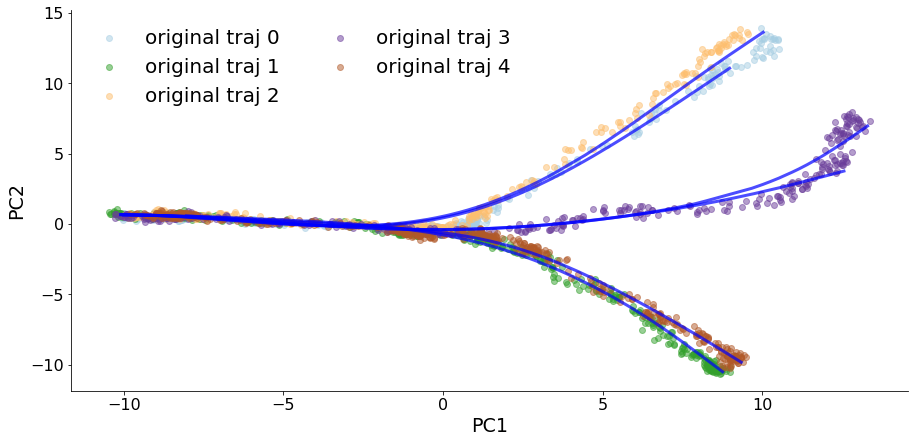

In [11]:
visual.traj_visual(cellpath_obj, trajs = num_trajs, figsize = (15,7), cmap = "Paired", save_as = None)

# Benchmark
## CellPaths
### Kendall-tau test


In [9]:
bmk.cellpath_kt(cellpath_obj)

{'traj_0': 0.9436447585856226,
 'traj_1': 0.9443532668805882,
 'traj_2': 0.9380921599335855,
 'traj_3': 0.935486508778067,
 'traj_4': 0.9407982078109284,
 'traj_5': 0.9334314229215517,
 'traj_6': 0.9396264931038536,
 'traj_7': 0.9417748271095533,
 'traj_8': 0.9409398104416246,
 'traj_9': 0.9421617724331258,
 'traj_10': 0.9409398104416246,
 'traj_11': 0.9404258583256789,
 'traj_12': 0.9400201856771138}

### Topology


In [12]:
bmk.f1_score(adata, method="CellPaths", paths = paths, greedy_paths = greedy_paths, trajs = 6)

recovery

inferred trajectory: 0 jaccard: 0.13028764805414553
inferred trajectory: 1 jaccard: 0.17043478260869566
inferred trajectory: 2 jaccard: 0.15760869565217392
inferred trajectory: 3 jaccard: 0.19096509240246407
inferred trajectory: 4 jaccard: 0.12984822934232715
inferred trajectory: 5 jaccard: 0.14777327935222673
recovery value: 0.15448628790200553
relevence

ori trajectory: 1 jaccard: 0.06851851851851852
ori trajectory: 2 jaccard: 0.17043478260869566
ori trajectory: 3 jaccard: 0.19096509240246407
ori trajectory: 4 jaccard: 0.13028764805414553
ori trajectory: 5 jaccard: 0.15760869565217392
relevence value: 0.14356294744719955


0.1488244504664032

In [19]:
bmk_belongings = bmk.purity_count(adata, method = "CellPaths", paths = paths, greedy_paths = greedy_paths, trajs = trajs)
entro = bmk.average_entropy(adata, bmk_belongings)
entro

1.513582646664952

### Slingshot

In [20]:
adata = anndata.read_h5ad("./sim_data/Dyngen/Trifurcating.h5ad")

X_pca = adata.obsm['X_pca']

n_clusters = 10
init = "k-means++"
n_init = 10
max_iter = 300
tol = 0.0001
kmeans = KMeans(n_clusters, init, n_init, max_iter, tol)
groups = kmeans.fit_predict(X_pca)
meta_data = adata.obs
meta_data['groups'] = groups

Text(0.5, 1.0, 'slingshot clusters')

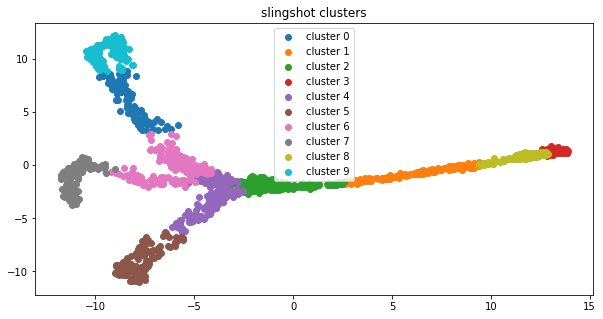

In [21]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()
c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
clusters = int(np.max(groups)+1)
for i in range(clusters):
    sub_cells = np.where(groups == i)[0]
    progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))
    # progression = ax.scatter(X_umap[sub_cells,0], X_umap[sub_cells,1], cmap = plt.get_cmap('Pastel1'))

ax.legend(['cluster '+ str(i) for i in range(clusters)])
ax.set_title("slingshot clusters")
# fig.savefig("./syn_results/dataset1/slingshot_clust.pdf")

In [22]:
X_pca_df = pd.DataFrame(index=[str(x) for x in range(X_pca.shape[0])], columns= np.arange(2), data = X_pca[:,0:2])
# scprep.run.install_bioconductor('slingshot')
results = scprep.run.Slingshot(X_pca_df, meta_data['groups'], start_cluster = 3)

R[write to console]: Using full covariance matrix


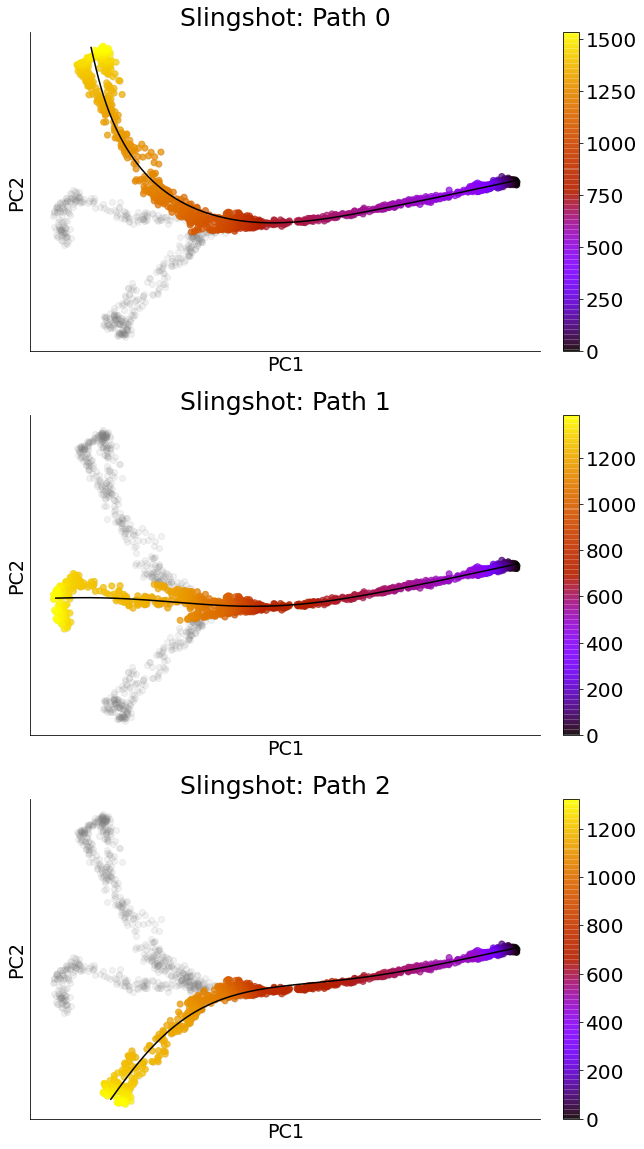

In [23]:
kt_slingshot = visual.slingshot_visual(adata,  results, basis= "pca", figsize=(10,20), save_as = None)

[Text(0, 0, ''),
 Text(0, 0, 'CellPaths'),
 Text(0, 0, 'Slingshot'),
 Text(0, 0, '')]

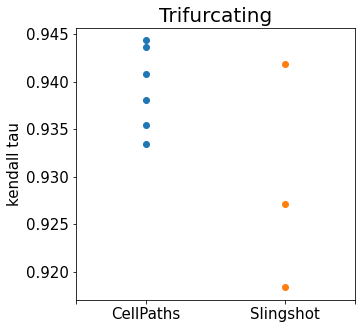

In [24]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
# ax.scatter(["CellPaths" for x in kt.values()], [x for x in kt.values()])
# ax.scatter(["slingshot" for x in kt_slingshot.values()], [x for x in kt_slingshot.values()])

ax.scatter([0 for x in kt.values()], [x for x in kt.values()])
ax.scatter([1 for x in kt_slingshot.values()], [x for x in kt_slingshot.values()])

ax.set_title("Trifurcating", fontsize = 20)
ax.set_ylabel("kendall tau", fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks([-0.5,0,1,1.5],fontsize = 15)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = ""
labels[1] = "CellPaths"
labels[2] = "Slingshot"
labels[3] = ""
ax.set_xticklabels(labels)
# fig.savefig("./sim_results/Dyngen/Trifurcating/quantity/boxplot.pdf", bbox_inches = "tight")

In [26]:
bmk.f1_score(adata, method="Slingshot", slingshot_result = results, trajs = 6)

recovery

inferred trajectory: 0 jaccard: 0.2834850455136541
inferred trajectory: 1 jaccard: 0.2984104046242775
inferred trajectory: 2 jaccard: 0.273620559334845
recovery value: 0.2851720031575922
relevence

ori trajectory: 1 jaccard: 0.273620559334845
ori trajectory: 2 jaccard: 0.2834850455136541
ori trajectory: 3 jaccard: 0.2660619803476946
ori trajectory: 4 jaccard: 0.2984104046242775
ori trajectory: 5 jaccard: 0.2824675324675325
relevence value: 0.28080910445760077


0.28297373797681147

In [29]:
bmk_belongings = bmk.purity_count(adata, method = "Slingshot", slingshot_result = results, trajs = trajs)
entro = bmk.average_entropy(adata, bmk_belongings)
entro

1.5680393614697745

In [2]:
adata = anndata.read_h5ad("./sim_data/Dyngen/Trifurcating.h5ad")
scv.tl.latent_time(adata)
latent_times = adata.obs.latent_time.values

Text(0.5, 1.0, &#39;velocity diffusion pseudo-time: Path 0&#39;)

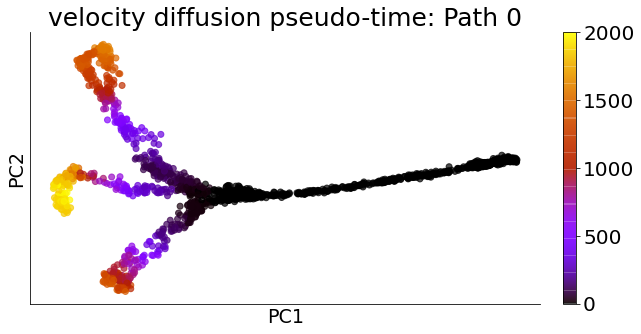

In [9]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()
X_pca = adata.obsm['X_pca']


pic = ax.scatter(X_pca[:,0],X_pca[:,1], alpha = 0.7, cmap = 'gnuplot', c = latent_times * X_pca.shape[0])
ax.tick_params(axis = "both", direction = "out", labelsize = 16)
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)
ax.set_title("scvelo latent time: Path " + str(0), fontsize = 25)